<a href="https://colab.research.google.com/github/devwithdave/pytrends/blob/master/PyTrends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTrends

Helpful links:

*   [Tutorial](https://searchengineland.com/learn-how-to-chart-and-track-google-trends-in-data-studio-using-python-329119)
*   [Github Documentation](https://github.com/GeneralMills/pytrends)
*   [Category Codes](https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories)
*   [Dataframe to Google Sheets](https://towardsdatascience.com/using-python-to-push-your-pandas-dataframe-to-google-sheets-de69422508f)


In [0]:
#@title Module Installs and Imports
!pip install --upgrade -q gspread pytrends
import pytrends
import time
import datetime
import gspread
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from datetime import datetime, date, time
from google.colab import auth
from pytrends.request import TrendReq
from oauth2client.client import GoogleCredentials
from pathlib import Path
clear_output()

If you would like to import a list of key words/phrases to use for Google Trends analysis, place a csv file with 1 phrase per row into the "data uploads" folder in the root of your Google Drive. Run the cell below and follow the instructions to login and mount your Google Drive, and type the full file name, including extension, into the `name_of_file` field below. 

If you would instead like to manually input your search terms (up to 5), **DO NOT RUN** the "Search Term Configuration" cell, and skip to the "Manul Search Term Entry" cell.

**ToDo**

*   Add checks for folder existance and file verification. 



In [0]:
#@title Google Drive Authenticate/Mount

from google.colab import drive
drive.mount('/content/drive')

In [0]:
#@title Search Term Configuration { form-width: "30%" }
upload_path = Path('drive/My Drive/data uploads')
name_of_file = "search terms.csv" #@param {type:"string"}
file_path = upload_path / name_of_file
if file_path.suffix == '.csv':
    import csv
    with open(file_path, newline='') as f:
        reader = csv.reader(f)
        results = list(reader)
        if len(results) <= 5:
            results = [item[0] for item in results]
        else:
            print('Large set detected.')
        print('These are the search terms loaded from your file:')
        print('='*20+'\n')
        print(*results, sep='\n')
else:
    print('Incorrect file name or type. Please verify file name and try again.')

In [0]:
#@title Manual Search Term Entry
# Replace the example list items with your own search terms (up to 5),
# making sure to enclose each in quotes (double or single),
# and separate each term with a comma.
results = [
           'smoothies',
           'slushies'
]

The following Interest Over Time plot will only work with 5 or less search terms. If your search term dataset has more than 5 terms, please proceed to the "Large Set Dataframe Creation" cell below.

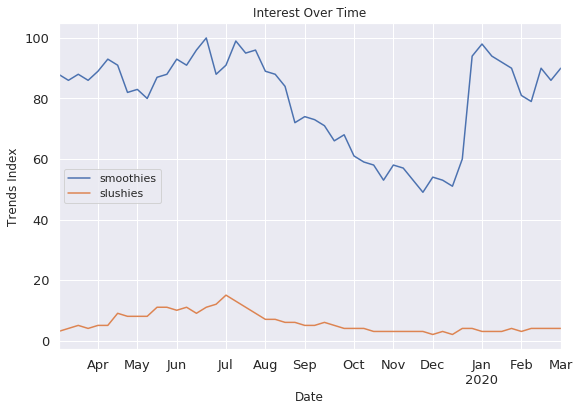

In [4]:
#@title Interest Over Time Plot (1 Year, US)
pytrend = TrendReq()
# Max list size = 5 items
pytrend.build_payload(
    kw_list=results, 
    timeframe='today 12-m', 
    geo = 'US')
interest_over_time_df = pytrend.interest_over_time()
sns.set(color_codes=True)
dx = interest_over_time_df.plot.line(
    figsize = (9,6), 
    title = "Interest Over Time")
dx.set_xlabel('Date')
dx.set_ylabel('Trends Index')
dx.tick_params(axis='both', which='major', labelsize=13)

The "Related Queries" cell below returns a dictionary of pandas dataframes based on the search terms provided above. The dictionary structure follows this pattern:

`{'1st Term':
    {'top': DataFrame,
    'rising': DataFrame},
'2nd Term':
    {'top': DataFrame,
    'rising': DataFrame},
etc...
}`

These dataframes can be accessed via dictionary keys, for example:

`related_queries['search term']['rising']`

Each DataFrame contains the search query and a value determining its search ranking.

In [0]:
#@title Related Queries
from pprint import pprint
related_queries = pytrend.related_queries()
print("Dictionary 'related_queries' created with the following keys:\n")
print(*[key for key in related_queries],sep='\n')

Dictionary 'related_queries' created with the following keys:

slushies
smoothies


In [0]:
#@title Large Set Dataframe Creation 
time_period = "today 3-m" #@param ["today 3-m", "today 12-m"]
data = {}

for index, trending in enumerate(results):
    pytrend.build_payload(trending, timeframe = time_period, geo = 'US')
    data[index] = pytrend.interest_over_time()

result = pd.concat(data, axis=1)
result.columns = result.columns.droplevel(0)
result = result.drop('isPartial', axis = 1)

result

In [0]:
#@title Authenticate Google User and Create Sheet
sheet_name = "Test Sheet" #@param {type:"string"}

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

# Create a new Google Sheet with `sheet_name`
sh = gc.create(sheet_name)
worksheet = gc.open(sheet_name).sheet1



In [0]:
def iter_pd(df):
    for val in df.columns:
        yield val
    for row in df.to_numpy():
        for val in row:
            if pd.isna(val):
                yield ""
            else:
                yield val

def pandas_to_sheets(pandas_df, sheet, clear=True):
    # Updates all values in a workbook to match a pandas dataframe
    if clear:
        sheet.clear()
    (row, col) = pandas_df.shape
    cells = sheet.range(f"A1:{gspread.utils.rowcol_to_a1(row + 1, col)}")
    for cell, val in zip(cells, iter_pd(pandas_df)):
        cell.value = val
    sheet.update_cells(cells)

In [0]:
result.to_excel('drive/My Drive/data exports/data.xlsx')